In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dydx(x,y):
    
    #set the derivatives
        
    #our equation is d^2y/dx^2= -y
    #so we can write
    #dydx = z
    #dzdx = -y
    #set y = y[0]
    #set z = y[1]
    
    #declare an array
    y_derivs = np.zeros(2)
    
    #set dydx = z
    y_derivs[0] = y[1]
    
    #set dzdx = -y
    y_derivs[1] = -1*y[0]
    
    #return array
    return y_derivs

In [3]:
def rk4_mv_core(dydx,xi,yi,nv,h,tol):
    
    
    #set arrays for coefficients
    a = np.array([1/5,3/40,9/40,3/10,-9/10,6/5,-11/54,5/2,-70/27,35/27,1631/55296,175/512,575/13824,44275/110592,253/4096]) 
    b = np.array([37/378,0,250/621,125/594,0,512/1771])
    b_star = np.array([2825/27648,0,18575/48384,13525/55296,277/14336,1/4])
    c = np.array([1/5,3/10,3/5,1,7/8])
    
    #declare k arrays
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    k5 = np.zeros(nv)
    k6 = np.zeros(nv)
    
    #Delta estimate
    delta = np.full(nv,2*tol)
    
     #define safety scale
    SAFETY = 0.9
    H_NEW_FAC = 2.0
    
    #set maximum number of iterations
    imax = 10000
    
    #set iteration variable
    i = 0
    
     #remember the step
    h_step = h
    
    while(delta.max()>tol):
        #k1
        y_derivs = dydx(xi,yi)
        k1[:] = h*y_derivs[:]
    
        #k2
        y_derivs = dydx(xi + c[0]*h,yi + a[0]*k1)
        k2[:] = h*y_derivs[:]
    
        #k3
        y_derivs = dydx(xi + c[1]*h, yi + a[1]*k1 + a[2]*k2)
        k3[:] = h*y_derivs[:]
    
        #k4
        y_derivs = dydx(xi + c[2]*h, yi + a[3]*k1 + a[4]*k2 + a[5]*k3)
        k4[:] = h*y_derivs[:]
    
        #k5
        y_derivs = dydx(xi + c[3]*h, yi + a[6]*k1 + a[7]*k2 + a[8]*k3 + a[9]*k4)
        k5[:] = h*y_derivs
    
        #k6
        y_derivs = dydx(xi + c[4]*h, yi + a[10]*k1 + a[11]*k2 + a[12]*k3 + a[13]*k4 + a[14]*k5)
        k6[:] = h*y_derivs[:]
    
        y_ipo = b[0]*k1 + b[1]*k2 + b[2]*k3 + b[3]*k4 + b[4]*k5 + b[5]*k6
    
        y_star_ipo = b_star[0]*k1 + b_star[1]*k2 + b_star[2]*k3 + b_star[3]*k4 + b_star[4]*k5 + b_star[5]*k6
        
        Delta = np.fabs(y_ipo - y_star_ipo)
        
         #if the error is too large, take a smaller step
        if(Delta.max()/tol > 1.0):
            
            #our error is too large, decrease the step
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
            
        # check iteration 
        if(i>=imax):
            print("Too many iteration in rk4_mv_ad()")
            raise StopIteration("Ending after i = ",i)
            
        #iterate
        i+=1
        
        h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9),h_step*H_NEW_FAC)
        
        return y_ipo, h_new, h_step


In [4]:
def rk4_mv(dfdx,w,z,y_w,tol):
    
    #dfdx is the derivative wrt x
    #w is the lower bound
    #z is the upper bound
    #y_a are the boundary conditions
    #tol is ther tolerance for integrating y
    
    #define our starting step
    xi = w
    yi = y_w.copy()
    
    #an initial step size == make very small!
    h = 1.0e-4 * (z-w)
    
    #set a maximum number of iterations
    imax = 10000
    
    #set an iteration variable
    i = 0
    
    #set the number of coupled odes to the
    #size of y_w
    nv = len(y_w)
    
    #set the initial conditions
    x = np.full(1,w)
    y = np.full((1,nv),y_w)
    
    #set a flag
    flag = 1
    
    #loop until we reach the right side
    while(flag):
        
        #calculate y_i+1
        yi_new,h_new,h_step = rk4_mv_core(dydx,xi,yi,nv,h,tol)
        
        #update the step
        h = h_new
        
        #prevent an overshoot
        if(xi+h_step>z):
            
            #take a smaller step
            h = z-xi
            
            #recalculate y_i+1
            yi_new, h_new, h_step = rk4_mv_core(dydx,xi,yi,nv,h,tol)
            
            #break
            flag = 0
            
        #update the values
        xi += h_step
        yi[:] = yi_new[:]
        
        #add the step to the arrays
        x = np.append(x,xi)
        y_new = np.zeros((len(x),nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
        
        #prevent too many iterations
        if(i>=imax):
            print("Maximum iterations reached")
            raise StopIteration("Iteration number = ",i)
            
        #iterate
        i += 1
        
        #output some information
        s = "i =%3d\tx = %9.8f\th = %9.8f\tz = %9.8f" % (i,xi,h_step,z)
        print(s)
        
        #break if new xi is == b
        if(xi==z):
            flag = 0
            
    return x,y 

In [5]:
w = 0.0
z = 2.0 * np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

#perform the integration
x,y = rk4_mv(dydx,w,z,y_0,tolerance)

i =  1	x = 0.00062832	h = 0.00062832	z = 6.28318531
i =  2	x = 0.00188496	h = 0.00125664	z = 6.28318531
i =  3	x = 0.00439823	h = 0.00251327	z = 6.28318531
i =  4	x = 0.00942478	h = 0.00502655	z = 6.28318531
i =  5	x = 0.01947787	h = 0.01005310	z = 6.28318531
i =  6	x = 0.03958407	h = 0.02010619	z = 6.28318531
i =  7	x = 0.07979645	h = 0.04021239	z = 6.28318531
i =  8	x = 0.16022123	h = 0.08042477	z = 6.28318531
i =  9	x = 0.32107077	h = 0.16084954	z = 6.28318531
i = 10	x = 0.64276986	h = 0.32169909	z = 6.28318531
i = 11	x = 1.28616803	h = 0.64339818	z = 6.28318531
i = 12	x = 2.57296438	h = 1.28679635	z = 6.28318531
i = 13	x = 5.14655709	h = 2.57359270	z = 6.28318531
i = 14	x = 6.28318531	h = 1.13662822	z = 6.28318531


<ipython-input-3-afc8443b70ff>:79: RuntimeWarning: divide by zero encountered in double_scalars
  h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9),h_step*H_NEW_FAC)


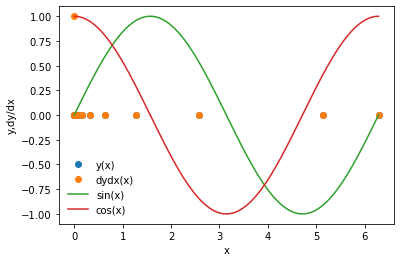

In [6]:
plt.plot(x,y[:,0],'o',label='y(x)')
plt.plot(x,y[:,1],'o',label='dydx(x)')
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx,np.sin(xx),label='sin(x)')
plt.plot(xx,np.cos(xx),label='cos(x)')
plt.xlabel('x')
plt.ylabel('y,dy/dx')
plt.legend(frameon=False)

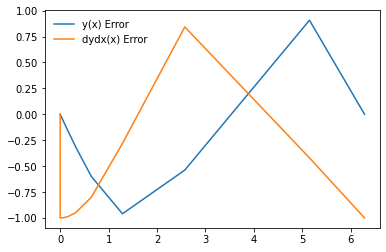

In [7]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0]-sine)
dydx_error = (y[:,1]-cosine)

plt.plot(x,y_error, label="y(x) Error")
plt.plot(x,dydx_error, label="dydx(x) Error")
plt.legend(frameon=False)